# I.Setup

## I.i Setup libraries

In [1]:
import os
import boto3

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import *
from pyspark.sql.functions import udf, broadcast
from pyspark.mllib.clustering import KMeans

import sagemaker
from sagemaker import get_execution_role
import sagemaker_pyspark

from PIL import Image, ImageOps, ImageFilter
import cv2 as cv


from pyspark.sql.functions import col, pandas_udf, PandasUDFType

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# get region
region = boto3.session.Session().region_name
# get bucket: hang's project 8 of openclassrooms
bucket_name = 'hangp8'

## I.ii Setup of SparkSession 
(ref: https://sagemaker-examples.readthedocs.io/en/latest/sagemaker-spark/pyspark_mnist/pyspark_mnist_kmeans.html#Setup)

In [3]:
role = get_execution_role()

# Configure Spark to use the SageMaker Spark dependency jars
jars = sagemaker_pyspark.classpath_jars()

classpath = ":".join(jars)

# Sets the Spark master URL to connect to, run locally with all cores available: 'local[*]'
spark = (
    SparkSession.builder.config("spark.driver.extraClassPath", classpath)
    .master("local[*]")
    .getOrCreate()
)

spark

# II. Image data
Access your files in S3 without copying files into your instance storage<br>
(ref:https://sagemaker-examples.readthedocs.io/en/latest/ingest_data/013_Ingest_image_data_v1.html?highlight=fs.ls#Method-1:-Streaming-data-from-S3-to-the-SageMaker-instance-memory)

## II.i Load label and list

In [117]:
# save img path and labels
# for exploration, we use train sample, which contains 3 categories, 1243 images
dir_prefix = 'train_sample/'
def get_path_label_list(prefix=dir_prefix, bucket_name=bucket_name):
    s3 = boto3.resource('s3', region_name=region)
    bucket=bucket_name
    my_bucket = s3.Bucket(bucket)
    path_label_list = []
    for (bucket_name, key) in map(lambda x: (x.bucket_name, x.key), my_bucket.objects.filter(Prefix=prefix)):
        # save img path
        img_location = "s3://{}/{}".format(bucket_name, key)
        # save img label
        img_label = img_location.split('/')[-2]
        path_label_list.append((img_location, img_label))
    # remove the root folder
    return path_label_list[1:]

In [118]:
# check result of function
path_label_list = get_path_label_list()
print('Show 1 line of path: {}\nThere are {} images in train_sample.'.format(path_label_list[0], len(path_label_list)))

Show 1 line of path: ('s3://hangp8/train_sample/Apple Pink Lady/100_100.jpg', 'Apple Pink Lady')
There are 1242 images in train_sample.


In [126]:
# create spark dataframe
def create_df(prefix=dir_prefix, bucket=bucket_name):
    data = get_path_label_list(prefix, bucket)
    columns = ['path', 'label']
    df_data = spark.createDataFrame(data).toDF(*columns)
    return df_data

In [127]:
# create a initial pyspark dataframe
df_data = create_df()
df_data.show(10, truncate=False)

+----------------------------------------------------+---------------+
|path                                                |label          |
+----------------------------------------------------+---------------+
|s3://hangp8/train_sample/Apple Pink Lady/100_100.jpg|Apple Pink Lady|
|s3://hangp8/train_sample/Apple Pink Lady/101_100.jpg|Apple Pink Lady|
|s3://hangp8/train_sample/Apple Pink Lady/102_100.jpg|Apple Pink Lady|
|s3://hangp8/train_sample/Apple Pink Lady/103_100.jpg|Apple Pink Lady|
|s3://hangp8/train_sample/Apple Pink Lady/104_100.jpg|Apple Pink Lady|
|s3://hangp8/train_sample/Apple Pink Lady/105_100.jpg|Apple Pink Lady|
|s3://hangp8/train_sample/Apple Pink Lady/106_100.jpg|Apple Pink Lady|
|s3://hangp8/train_sample/Apple Pink Lady/107_100.jpg|Apple Pink Lady|
|s3://hangp8/train_sample/Apple Pink Lady/108_100.jpg|Apple Pink Lady|
|s3://hangp8/train_sample/Apple Pink Lady/109_100.jpg|Apple Pink Lady|
+----------------------------------------------------+---------------+
only s

## II.ii Preprocess
Preprocess including autocontrast, equalization and compute ORB descriptors

In [128]:
def preprocess(path_img):
    
    '''for each image: create preprocessed image array and orb descriptors'''
    
    my_bucket = bucket_name
    # get in-bucket path
    key = os.path.relpath(path_img, 's3://'+bucket_name+'/')
    
    image_object = boto3.resource("s3", region_name=region).Bucket(my_bucket).Object(key)
    img = Image.open(image_object.get()["Body"])
    
    # preprocess
    # remove 1% extreme lightest and darkest pixels then maximize image contrast
    tmp1 = ImageOps.autocontrast(img, cutoff=1)
    # equalize image histogram to creat a uniform distribution of grayscale
    tmp2 = ImageOps.equalize(tmp1)
    img_out = tmp2
    img_prep = np.array(img_out).flatten().tolist()
    
    # descriptors
    # set max feature to retain = 50
    orb = cv.ORB_create(nfeatures=50)
    _, des = orb.detectAndCompute(np.array(img_out),None)
    img_des = ([] if des is None else des.flatten().tolist())
    
    return (img_prep, img_des)

In [129]:
schema = StructType([
    StructField("img_prep", ArrayType(IntegerType()), False),
    StructField("img_orb_des", ArrayType(IntegerType()), False)])

preprocess_udf = udf(preprocess, schema)

df_data = df_data.withColumn("Output", preprocess_udf('path'))

In [130]:
df_data.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- Output: struct (nullable = true)
 |    |-- img_prep: array (nullable = false)
 |    |    |-- element: integer (containsNull = true)
 |    |-- img_orb_des: array (nullable = false)
 |    |    |-- element: integer (containsNull = true)



In [131]:
df_data.select('path', 'label', 'Output.*').show()

+--------------------+---------------+--------------------+--------------------+
|                path|          label|            img_prep|         img_orb_des|
+--------------------+---------------+--------------------+--------------------+
|s3://hangp8/train...|Apple Pink Lady|[255, 255, 255, 2...|[223, 22, 255, 24...|
|s3://hangp8/train...|Apple Pink Lady|[255, 255, 255, 2...|[237, 253, 189, 1...|
|s3://hangp8/train...|Apple Pink Lady|[255, 255, 255, 2...|[223, 22, 255, 25...|
|s3://hangp8/train...|Apple Pink Lady|[255, 255, 255, 2...|[191, 180, 253, 2...|
|s3://hangp8/train...|Apple Pink Lady|[255, 255, 255, 2...|[223, 28, 191, 25...|
|s3://hangp8/train...|Apple Pink Lady|[255, 255, 255, 2...|[74, 60, 187, 240...|
|s3://hangp8/train...|Apple Pink Lady|[255, 255, 255, 2...|[139, 158, 107, 2...|
|s3://hangp8/train...|Apple Pink Lady|[255, 255, 255, 2...|[138, 184, 186, 1...|
|s3://hangp8/train...|Apple Pink Lady|[255, 255, 255, 2...|[154, 184, 187, 1...|
|s3://hangp8/train...|Apple 

### II. iii KMEANS ORB

In [132]:
# convert flatten descriptors to orb ndarray descriptors (n, 32)
rdd_data = df_data.rdd.map(lambda x: Row(path = x.path,\
                                         label = x.label,\
                                         img_prep = np.array(x['Output']['img_prep']).reshape(100, 100, 3),\
                                         img_orb_des = np.array(x['Output']['img_orb_des']).reshape(-1, 32)
                                        )
                          )
# check orb descriptors of 1st image
rdd_data.first()

Row(img_orb_des=array([[223,  22, 255, 247, 174, 126, 255, 159, 255, 254, 191, 246, 221,
        126, 223, 111, 255, 215, 255, 167, 181, 229, 255, 234, 255, 255,
        127, 142, 143, 253, 173, 117],
       [ 11, 158, 255, 253,  50, 191, 121,  55,  63,  75, 126, 244, 188,
         63, 132, 100, 231,  63,  63, 140, 163, 156,  33, 255, 198, 255,
        122, 130,  30, 192, 161, 121],
       [ 10,  24, 187, 249,  55, 244, 185,  87, 191,  79,  86, 119, 188,
        191,  34, 232, 231,  59, 191, 145, 147, 156,  50, 227, 199, 247,
         58, 203, 154,  68,  37, 251],
       [201, 156,  62, 249,  57, 255, 121,  55, 189,  95,  62,  84, 190,
         63,  34, 115, 167,  51, 127,   8, 179, 205,  51, 215, 207, 251,
        122, 194, 154, 128, 133, 123],
       [138, 156,  63, 249,  51, 253, 185,  87, 191,  95,  86,  51, 188,
        159,  34, 105, 167,  51, 223,  17, 179, 205,  50, 247, 207, 215,
         58, 195, 154,   4, 173, 251],
       [202, 184, 191, 252, 233, 252, 117,  55, 185,  95, 2

In [ ]:
# list all descriptors for latter use in kmeans
all_desp = rdd_data.flatMap(lambda row: [i for i in row['img_orb_des']])

In [ ]:
from pyspark.mllib.clustering import KMeans
# k is n_cluster, suppose 10*categories
k = 10
def create_model(rdd, k):
    """Create kmeans model to create visual words cluster"""
    all_desp = rdd.flatMap(lambda row: [i for i in row['img_orb_des']])
    model = KMeans.train(all_desp, k, maxIterations=10, initializationMode="random", seed=42)
    return model

In [109]:
model_kmeans = create_model(rdd_data, k)
model_kmeans.predict(all_desp)

PythonRDD[318] at RDD at PythonRDD.scala:53

In [110]:
model_kmeans.predict(all_desp).first()

9

In [111]:
rdd_data.map(lambda row: row['img_orb_des']).first()

array([[191, 253, 248, 250, 159, 245, 223, 222,  83, 127, 180,  31,  42,
        253,  95, 173, 221, 219, 149, 147, 190, 110, 250, 179, 251, 221,
        157, 127, 255,  93, 222, 223],
       [217, 151, 125, 229,  36, 118,  95, 187,  49, 106, 127, 118, 223,
         63, 154, 243, 119, 213, 181, 238, 249, 244, 121, 143, 230, 251,
        227, 132,  47, 225, 200, 113],
       [190, 220, 126, 250, 207, 247, 159, 254, 155,  95, 221,  31, 108,
        255,  62, 205, 255, 251, 183, 135, 252, 199,  58, 255, 251, 255,
        223, 219, 183,  95, 173, 223],
       [207, 188, 255, 214, 183, 255, 189, 179, 187, 255,  23,  52, 252,
        255, 222, 175, 167, 119, 253,  19, 245, 221, 187, 230, 107,  95,
        127, 195, 142, 228, 205, 119],
       [142, 189, 191, 254, 175, 246, 191, 214, 187,  95, 215, 183, 124,
        255, 191, 175, 247, 127, 181, 147, 177, 205, 186, 235, 123, 127,
        254, 131, 135, 245, 167, 123],
       [138, 156, 255, 254, 247, 246, 255, 246, 153,  79, 124,  50, 252,
  

In [112]:
def bovw(row, model, k):
    n_des = len(row.img_orb_des)
    bovw = np.zeros(k)
    for des_ in row.img_orb_des:
        cluster = model.predict(des_)
        #normalize freq
        bovw[cluster] += 1/n_des
    return Row(path=row.path, label=row.label, bovw=bovw.tolist())

In [113]:
bovw_rdd = rdd_data.map(lambda x: bovw(x, model_kmeans, k))

In [114]:
bovw_rdd.toDF().show()

+--------------------+------------------+--------------------+
|                bovw|             label|                path|
+--------------------+------------------+--------------------+
|[0.0, 0.176470588...|Apple Golden Small|s3://hangp8/train...|
|[0.0, 0.2, 0.05, ...|Apple Golden Small|s3://hangp8/train...|
|[0.04761904761904...|Apple Golden Small|s3://hangp8/train...|
|[0.05, 0.15000000...|Apple Golden Small|s3://hangp8/train...|
|[0.0, 0.045454545...|Apple Golden Small|s3://hangp8/train...|
|[0.05, 0.05, 0.05...|Apple Golden Small|s3://hangp8/train...|
|[0.04761904761904...|Apple Golden Small|s3://hangp8/train...|
+--------------------+------------------+--------------------+



# III. Compare instances
By using integrated .py file to compare processing time of different instances

## III.i Instance ml.t3.medium

In [1]:
# Run load and preprocess using standard instance ml.t3.medium(2*cpu, 4GB memory)
%run -i 'P8_script.py'

+--------------------+---------------+--------------------+
|                bovw|          label|                path|
+--------------------+---------------+--------------------+
|[0.0, 0.0, 0.0, 0...|Apple Pink Lady|s3://hangp8/train...|
|[0.0, 0.0, 0.0, 0...|Apple Pink Lady|s3://hangp8/train...|
|[0.0, 0.0, 0.0, 0...|Apple Pink Lady|s3://hangp8/train...|
|[0.0, 0.0, 0.125,...|Apple Pink Lady|s3://hangp8/train...|
|[0.0, 0.0, 0.1538...|Apple Pink Lady|s3://hangp8/train...|
|[0.0, 0.0, 0.0909...|Apple Pink Lady|s3://hangp8/train...|
|[0.0, 0.0, 0.1818...|Apple Pink Lady|s3://hangp8/train...|
|[0.0, 0.0, 0.2142...|Apple Pink Lady|s3://hangp8/train...|
|[0.0, 0.0, 0.0769...|Apple Pink Lady|s3://hangp8/train...|
|[0.0, 0.0, 0.0714...|Apple Pink Lady|s3://hangp8/train...|
+--------------------+---------------+--------------------+
only showing top 10 rows

total loading and preprocess time: 00:05:02,
4821 images,
10 categories


In [5]:
# export dataframe under ml.t3.medium(2*cpu, 4GB memory)
df_final.select('path').show(truncate=False)

+----------------------------------------------------+
|path                                                |
+----------------------------------------------------+
|s3://hangp8/train_sample/Apple Pink Lady/0_100.jpg  |
|s3://hangp8/train_sample/Apple Pink Lady/100_100.jpg|
|s3://hangp8/train_sample/Apple Pink Lady/101_100.jpg|
|s3://hangp8/train_sample/Apple Pink Lady/102_100.jpg|
|s3://hangp8/train_sample/Apple Pink Lady/103_100.jpg|
|s3://hangp8/train_sample/Apple Pink Lady/104_100.jpg|
|s3://hangp8/train_sample/Apple Pink Lady/105_100.jpg|
|s3://hangp8/train_sample/Apple Pink Lady/106_100.jpg|
|s3://hangp8/train_sample/Apple Pink Lady/107_100.jpg|
|s3://hangp8/train_sample/Apple Pink Lady/108_100.jpg|
|s3://hangp8/train_sample/Apple Pink Lady/109_100.jpg|
|s3://hangp8/train_sample/Apple Pink Lady/10_100.jpg |
|s3://hangp8/train_sample/Apple Pink Lady/110_100.jpg|
|s3://hangp8/train_sample/Apple Pink Lady/111_100.jpg|
|s3://hangp8/train_sample/Apple Pink Lady/112_100.jpg|
|s3://hang

## III.i Instance ml.c5.2xlarge

In [1]:
# manually change instance to c5.2xlarge
# Run load and preprocess using compute optimized instance ml.c5.2xlarge(8*cpu, 16GB memory), 5GB EBS
%run -i 'P8_script.py'

+--------------------+---------------+--------------------+
|                bovw|          label|                path|
+--------------------+---------------+--------------------+
|[0.0, 0.0, 0.0, 0...|Apple Pink Lady|s3://hangp8/train...|
|[0.0, 0.0, 0.0833...|Apple Pink Lady|s3://hangp8/train...|
|[0.0, 0.1, 0.0, 0...|Apple Pink Lady|s3://hangp8/train...|
|[0.0, 0.0, 0.0, 0...|Apple Pink Lady|s3://hangp8/train...|
|[0.0, 0.0, 0.0, 0...|Apple Pink Lady|s3://hangp8/train...|
|[0.0, 0.0, 0.0, 0...|Apple Pink Lady|s3://hangp8/train...|
|[0.0, 0.0, 0.0, 0...|Apple Pink Lady|s3://hangp8/train...|
|[0.0, 0.0, 0.0, 0...|Apple Pink Lady|s3://hangp8/train...|
|[0.0, 0.0, 0.0, 0...|Apple Pink Lady|s3://hangp8/train...|
|[0.0, 0.0, 0.0, 0...|Apple Pink Lady|s3://hangp8/train...|
+--------------------+---------------+--------------------+
only showing top 10 rows

total loading and preprocess time: 00:01:52,
4821 images,
10 categories


In [1]:
# keep instance, manually change EBS to 30GB
# Run load and preprocess using compute optimized instance ml.c5.2xlarge(8*cpu, 16GB memory), 30GB EBS
%run -i 'P8_script.py'

+--------------------+---------------+--------------------+
|                bovw|          label|                path|
+--------------------+---------------+--------------------+
|[0.0, 0.0, 0.0, 0...|Apple Pink Lady|s3://hangp8/train...|
|[0.0, 0.0, 0.0833...|Apple Pink Lady|s3://hangp8/train...|
|[0.0, 0.1, 0.0, 0...|Apple Pink Lady|s3://hangp8/train...|
|[0.0, 0.0, 0.0, 0...|Apple Pink Lady|s3://hangp8/train...|
|[0.0, 0.0, 0.0, 0...|Apple Pink Lady|s3://hangp8/train...|
|[0.0, 0.0, 0.0, 0...|Apple Pink Lady|s3://hangp8/train...|
|[0.0, 0.0, 0.0, 0...|Apple Pink Lady|s3://hangp8/train...|
|[0.0, 0.0, 0.0, 0...|Apple Pink Lady|s3://hangp8/train...|
|[0.0, 0.0, 0.0, 0...|Apple Pink Lady|s3://hangp8/train...|
|[0.0, 0.0, 0.0, 0...|Apple Pink Lady|s3://hangp8/train...|
+--------------------+---------------+--------------------+
only showing top 10 rows

total loading and preprocess time: 00:01:54,
4821 images,
10 categories


In [2]:
# export dataframe under ml.c5.2xlarge(8*cpu, 16GB memory) 30GB EBS
df_final.select('path').show(truncate=False)

+----------------------------------------------------+
|path                                                |
+----------------------------------------------------+
|s3://hangp8/train_sample/Apple Pink Lady/0_100.jpg  |
|s3://hangp8/train_sample/Apple Pink Lady/100_100.jpg|
|s3://hangp8/train_sample/Apple Pink Lady/101_100.jpg|
|s3://hangp8/train_sample/Apple Pink Lady/102_100.jpg|
|s3://hangp8/train_sample/Apple Pink Lady/103_100.jpg|
|s3://hangp8/train_sample/Apple Pink Lady/104_100.jpg|
|s3://hangp8/train_sample/Apple Pink Lady/105_100.jpg|
|s3://hangp8/train_sample/Apple Pink Lady/106_100.jpg|
|s3://hangp8/train_sample/Apple Pink Lady/107_100.jpg|
|s3://hangp8/train_sample/Apple Pink Lady/108_100.jpg|
|s3://hangp8/train_sample/Apple Pink Lady/109_100.jpg|
|s3://hangp8/train_sample/Apple Pink Lady/10_100.jpg |
|s3://hangp8/train_sample/Apple Pink Lady/110_100.jpg|
|s3://hangp8/train_sample/Apple Pink Lady/111_100.jpg|
|s3://hangp8/train_sample/Apple Pink Lady/112_100.jpg|
|s3://hang

## III.i Instance ml.m5.2xlarge

In [1]:
# manually change instance to m5.2xlarge
# Run load and preprocess using standard instance ml.m5.2xlarge(8*cpu, 32GB memory), 5GB EBS 
%run -i 'P8_script.py'

+--------------------+---------------+--------------------+
|                bovw|          label|                path|
+--------------------+---------------+--------------------+
|[0.0, 0.0, 0.0, 0...|Apple Pink Lady|s3://hangp8/train...|
|[0.0, 0.0, 0.0833...|Apple Pink Lady|s3://hangp8/train...|
|[0.0, 0.1, 0.0, 0...|Apple Pink Lady|s3://hangp8/train...|
|[0.0, 0.0, 0.0, 0...|Apple Pink Lady|s3://hangp8/train...|
|[0.0, 0.0, 0.0, 0...|Apple Pink Lady|s3://hangp8/train...|
|[0.0, 0.0, 0.0, 0...|Apple Pink Lady|s3://hangp8/train...|
|[0.0, 0.0, 0.0, 0...|Apple Pink Lady|s3://hangp8/train...|
|[0.0, 0.0, 0.0, 0...|Apple Pink Lady|s3://hangp8/train...|
|[0.0, 0.0, 0.0, 0...|Apple Pink Lady|s3://hangp8/train...|
|[0.0, 0.0, 0.0, 0...|Apple Pink Lady|s3://hangp8/train...|
+--------------------+---------------+--------------------+
only showing top 10 rows

total loading and preprocess time: 00:02:09,
4821 images,
10 categories


# Export data to S3

In [2]:
# manually change instance
# write data to S3 using instance ml.t3.medium(2*cpu, 4GB memory)
t = time.time() 
df_final = bovw_rdd.toDF()
df_final.write.parquet('s3a://{}/output_sample/'.format(bucket_name), mode="overwrite")
print('save in S3 successfully!\nTotal export time using ml.t3.medium: {}'.format(time.strftime("%H:%M:%S", time.gmtime(time.time()-t))))

save in S3 successfully!
Total export time using ml.t3.medium: 00:04:26


In [3]:
# manually change instance
# write data to S3 using instance ml.c5.2xlarge(8*cpu, 16GB memory)
t = time.time() 
df_final = bovw_rdd.toDF()
df_final.write.parquet('s3a://{}/output_sample/'.format(bucket_name), mode="overwrite")
print('save in S3 successfully!\nTotal export time using ml.c5.2xlarge: {}'.format(time.strftime("%H:%M:%S", time.gmtime(time.time()-t))))

save in S3 successfully!
Total export time using ml.c5.2xlarge: 00:01:32


In [4]:
# manually change instance
# write data to S3 using instance ml.m5.2xlarge(8*cpu, 32GB memory)
t = time.time() 
df_final = bovw_rdd.toDF()
df_final.write.parquet('s3a://{}/output_sample/'.format(bucket_name), mode="overwrite")
print('save in S3 successfully!\nTotal export time using ml.m5.2xlarge: {}'.format(time.strftime("%H:%M:%S", time.gmtime(time.time()-t))))

save in S3 successfully!
Total export time using ml.m5.2xlarge: 00:01:30


In [183]:
# check if data has been correctly saved in S3
# read parquet from s3
df_check = spark.read.parquet('s3a://hangp8/output_sample/')
df_check.printSchema()

root
 |-- bovw: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- label: string (nullable = true)
 |-- path: string (nullable = true)



In [184]:
df_check.select('path', 'label', 'bovw').show(5)

+--------------------+--------------+--------------------+
|                path|         label|                bovw|
+--------------------+--------------+--------------------+
|s3://hangp8/train...|Cherry Rainier|[0.0, 0.0, 0.0, 0...|
|s3://hangp8/train...|Cherry Rainier|[0.0, 0.0, 0.0476...|
|s3://hangp8/train...|Cherry Rainier|[0.0, 0.0, 0.0869...|
|s3://hangp8/train...|Cherry Rainier|[0.0, 0.0, 0.0, 0...|
|s3://hangp8/train...|Cherry Rainier|[0.0, 0.0, 0.0869...|
+--------------------+--------------+--------------------+
only showing top 5 rows



In [185]:
df_check.count()

4821

In [186]:
df_check.select('label').distinct().count()

10

# Brouillons
Exploration on a single image

## Import and export single image to S3

In [1]:
from PIL import Image, ImageOps, ImageFilter
import matplotlib.pyplot as plt
import cv2 as cv

In [3]:
from PIL import Image
from io import BytesIO
import numpy as np
def read_image_from_s3(path, region_name=region, bucket='hangtestbucket'):
    """Load image file from s3.

    Parameters
    ----------
    bucket: string
        Bucket name
    path : string
        Path in s3

    Returns
    -------
    np array
        Image array
    """
    s3 = boto3.resource('s3', region_name=region_name)
    bucket = s3.Bucket(bucket)
    object = bucket.Object(path)
    response = object.get()
    file_stream = response['Body']
    im = Image.open(file_stream)
    return im
    #return np.array(im)

def write_image_to_s3(img_array, path, region_name=region, bucket='hangtestbucket'):
    """Write an image array into S3 bucket

    Parameters
    ----------
    bucket: string
        Bucket name
    path : string
        Path in s3

    Returns
    -------
    None
    """
    s3 = boto3.resource('s3', region_name)
    bucket = s3.Bucket(bucket)
    object = bucket.Object(path)
    file_stream = BytesIO()
    im = Image.fromarray(img_array)
    im.save(file_stream, format='jpeg')
    object.put(Body=file_stream.getvalue())

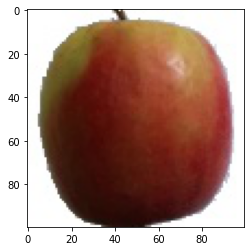

In [5]:
import matplotlib.pyplot as plt
img = read_image_from_s3(path='75_100.jpg')

plt.imshow(np.array(img))

In [6]:
# autocontrast img to prevent over-exposition and under-exposition
tmp1 = ImageOps.autocontrast(img, cutoff=1)
# equalize image histogram to creat a uniform distribution of grayscale
tmp2 = ImageOps.equalize(tmp1)

In [10]:
def display_img(imgs=list, title=None, size=3):
    """This function display all images in imgs list"""
    n = len(imgs)
    plt.figure(figsize=(size*n,size))
    t = range(n) if title==None else title
    for img, i in zip(imgs, range(n)):
        plt.subplot(1,n,i+1), plt.imshow(img, cmap='gray'), plt.title(t[i])
    plt.show()

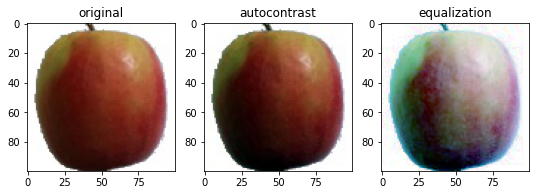

In [11]:
display_img(imgs=[img, tmp1, tmp2], title=['original', 'autocontrast', 'equalization'])

In [46]:
write_image_to_s3(img, path='export_test.jpeg')

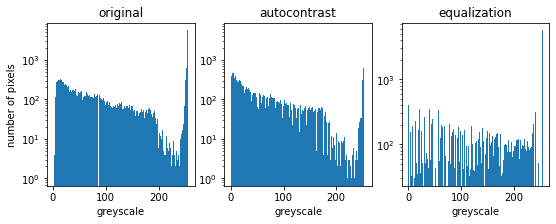

In [9]:
# change of histogram of grey level
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for img_, i, title_ in zip([img, tmp1, tmp2], range(3),
                           ['original', 'autocontrast', 'equalization'] ):
    tmp = np.array(img_).flatten()
    ax[i].hist(tmp, bins=256, log=(0,1))
    ax[i].set(title=title_, xlabel='greyscale',
              ylabel=['number of pixels' if i==0 else None][0] )